In [1]:
# , TaskLoader, construct_circ_time_ds
from deepsensor.data import DataProcessor
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import lab as B
import numpy as np
import torch.optim as optim
from tqdm import tqdm_notebook, tqdm
import pandas as pd
import xarray as xr
from deepsensor.data import TaskLoader
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.model import ConvNP
import deepsensor.torch
import logging

logging.captureWarnings(True)

/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/site-packages/fdm/fdm.py:44: DeprecationWa

In [2]:
# Open netcdf of AMSR derived SIC
amsr_raw_ds = xr.open_dataset(
    "/data/hpcdata/users/marrog/DeepSensor_code/sea_ice_code/SIC_amsr_stack_3031_time_temp5.nc")

# Retaining land variable until this point, in case I subsequently want to use it.
amsr_raw_ds = amsr_raw_ds.drop(['land'])

# Trying new AMSR dataset in epsg 3031.
data_processor = DataProcessor(x1_name="y", x2_name="x", verbose=True)
print(type(data_processor))
amsr_ds = data_processor(amsr_raw_ds)


task_loader = TaskLoader(
    context=[amsr_ds]*2,
    target=[amsr_ds],
    context_delta_t=[-1, 0],
    target_delta_t=0,
    #links = [(1, 0)]
)
print(task_loader.context_dims)
amsr_ds

<class 'deepsensor.data.processor.DataProcessor'>
Normalisation params for sea_ice_concentration not computed. Computing now... Done. sea_ice_concentration mean_std params={'mean': 78.04472351074219, 'std': 33.666561126708984}
Inferring x1_map=(820052.4534908909, 2838808.8697723807) and x2_map=(-2625435.9375827303, -606679.5213012407) from data min/max
(1, 1)


<xarray.Dataset>
Dimensions:                (time: 40, x1: 325, x2: 645)
Coordinates:
  * time                   (time) datetime64[ns] 2021-10-20 ... 2021-11-28
  * x1                     (x1) float64 0.0 0.001556 0.003112 ... 0.5016 0.5031
  * x2                     (x2) float64 0.0 0.001561 0.003117 ... 0.9984 1.0
Data variables:
    sea_ice_concentration  (time, x1, x2) float32 -2.318 -2.318 ... 0.6521
Attributes: (12/17)
    title:              Daily averaged Antarctic sea ice concentration derive...
    description:        gridded ASI AMSR2 sea ice concentration
    history:            Created Thu Oct 21 12:21:07 2021
    sensor:             AMSR2
    datasource:         JAXA L1R v2
    netCDF_created_by:  Xiangshan Tian-Kunze, xiangshan.tiankunze@awi.de
    ...                 ...
    grid:               NSIDC polar stereographic with tangential plane at 70...
    grid_resolution:    3.125 km
    Comment:            List of swath files used for the daily mean: ['GW1AM2...
    geocorrection:      none
    contact:            xiangshan.tiankunze@awi.de
    Summary:            The land is not masked out in the data. The user shou...

In [3]:
train_tasks = []
for date in pd.date_range("2021-10-22", "2021-10-22"):
    task = task_loader(date, context_sampling=["all", "all"], target_sampling="all",
                       patch_strategy="sliding", patch_size=(0.5, 0.5), stride=(0.5, 0.5))
    # task.remove_context_nans().remove_target_nans() ## comment to Nils
    i = 0
    for t in task:

        #
        print(t['bbox'])
        print(t['X_t'][0][0][0][0], t['Y_t'][0][0][0][0])
        print(t['X_t'][0][0][0].shape, t['Y_t'][0][0][0].shape)
        #print('t type', type(t))
        i = i+1
        # print(t['X_t'].values)
        # train_tasks.append(t)
print("number of patches", i)

[0.0, 0.5, 0.0, 0.5]
0.0 -2.3181674
(322,) (323,)
[0.0, 0.5, 0.5, 1.0]
0.0 -0.017665148
(322,) (322,)
[0.0031113028526306152, 0.5031113028526306, 0.0, 0.5]
0.003111993 -2.3181674
(323,) (323,)
[0.0031113028526306152, 0.5031113028526306, 0.5, 1.0]
0.003111993 0.13144422
(323,) (322,)
number of patches 4


In [4]:
model = ConvNP(data_processor, task_loader)
for t in task:
    encoding = deepsensor.model.nps.compute_encoding_tensor(model, t)
    print(f"SetConv encoding tensor shape: {encoding.shape}")

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 643
encoder_scales inferred from TaskLoader: [0.000776397529989481, 0.000776397529989481]
decoder_scale inferred from TaskLoader: 0.0015552099533437014


SetConv encoding tensor shape: (1, 4, 464, 464)
SetConv encoding tensor shape: (1, 4, 464, 464)
SetConv encoding tensor shape: (1, 4, 464, 464)
SetConv encoding tensor shape: (1, 4, 464, 464)


In [5]:
# Set up model
# Internal_density works similar to the manual pooling task I was previously conducting.
# It effectively reduces the resolution and thus size of the images.
# Hopefully this step can be removed once patching is in place.
opt = optim.Adam(model.model.parameters(), lr=5e-5)

# Calculate the number of tasks
task_count = len(train_tasks)

# Produce list [0, task_count]
task_entries = list(range(0, task_count))

# Permute list to assign order tasks applied to model
tasks_shuffled = np.random.permutation(task_entries)

# Set the number of tasks in each sublist
len_sublist = 3

# Split the original list into sublists
sublists = [tasks_shuffled[i:i+len_sublist]
            for i in range(0, len(tasks_shuffled), len_sublist)]
print(sublists)

n_epochs = 3

# Train model
for epoch in tqdm(range(n_epochs)):
    for sublist in sublists:  # currently sublist is a subset of 3 of the tasks
        task_losses = []
        for i in sublist:
            task_i = train_tasks[i]
            opt.zero_grad()
            task_losses.append(model.loss_fn(task_i, normalise=True))
        mean_batch_loss = B.mean(B.stack(*task_losses))
        mean_batch_loss.backward()
        opt.step()


[]


100%|██████████| 3/3 [00:00<00:00, 14944.08it/s]


In [15]:

patch_size = (0.2, 0.2)
stride = (0.18, 0.18)
date = "2021-11-21"
# Test when I do patch
test_task = task_loader(date, context_sampling=["all", "all"], target_sampling="all",
                        patch_strategy="sliding", patch_size=patch_size, stride=stride)

# Note, i need to make data processor an obligatory input for predict_patch
patched_preds = model.predict_patch(test_task, X_t=amsr_raw_ds, data_processor = data_processor)

#overlap = preds[0]['sea_ice_concentration']['x'].values.min() - preds[1]['sea_ice_concentration']['x'].values.min()
#vars = list(preds[0].data_vars)

print(patched_preds)
#preds

Prediction({'sea_ice_concentration': ('mean', 'std')}), mode=on-grid


TypeError: list indices must be integers or slices, not str

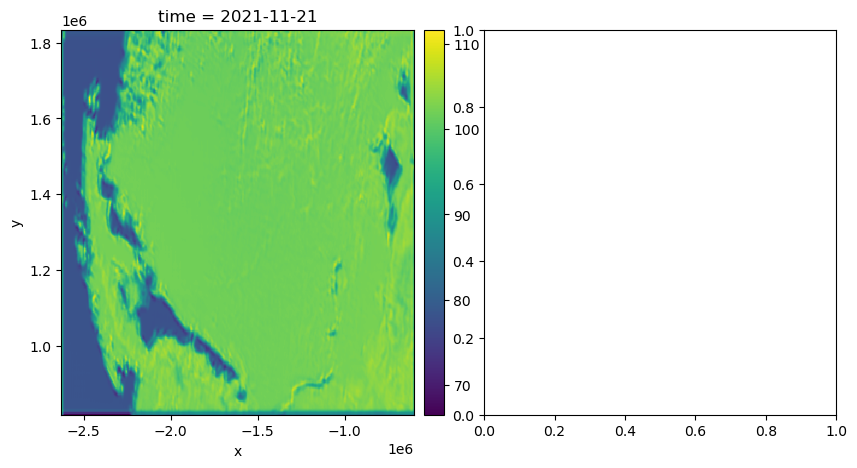

In [11]:
fig = deepsensor.plot.prediction(patched_preds, date, data_processor, task_loader, test_task)

In [ ]:
def get_patches_per_row(preds):
    """
    Calculate number of patches per row. 
    Required to stitch patches back together. 
    Args:
        preds (List[class:`~.model.pred.Prediction`]):
                A list of `dict`-like objects containing patchwise predictions.
    
    Returns:
        patches_per_row (int)
            Number of patches per row.
    """   
    patches_per_row = 0
    vars = list(preds[0][0].data_vars)
    var = vars[0]

    for p in preds:
        if p[0][var].coords['y'].min() == amsr_raw_ds.coords['y'].min():
            patches_per_row = patches_per_row + 1  
    
    return patches_per_row

patches_per_row = get_patches_per_row(preds)

In [ ]:
### Start of reproducing what is in predict_patch so that I can add in the stitching element ###
import copy
# Create blank prediction dataframe. 
pred_copy = copy.deepcopy(preds[0])
X_t=amsr_raw_ds # to remove 
#print(X_t['x'], X_t['y']) # to remove
# Generate new blank DeepSensor.prediction object in original coordinate system.
for var_name_copy, data_array_copy in pred_copy.items():

    # set x and y coords to entire extent
    stitched_preds = xr.Dataset(coords={'x': X_t['x'], 'y': X_t['y']})

    # Set time to same as patched prediction
    stitched_preds['time'] = data_array_copy['time']

    # set variable names to those in patched prediction, make values blank
    for var_name_i in data_array_copy.data_vars:
        stitched_preds[var_name_i] = data_array_copy[var_name_i]
        stitched_preds[var_name_i][:] = np.nan
    pred_copy[var_name_copy]= stitched_preds



pred_copy



NameError: name 'preds' is not defined

In [ ]:
patch_size_i = 0.25
patch_size = (0.25, 0.25)
print(type(patch_size))
print(type(patch_size_i))

<class 'tuple'>
<class 'float'>


In [ ]:
# Calculate overlap between adjacent patches in pixels
def convert_to_index(data, data_processor, amsr_raw_ds):
    bbox = [0, data[0], 0, data[1]]
    x1 = xr.DataArray([bbox[0], bbox[1]], dims='x1', name='x1')
    x2 = xr.DataArray([bbox[2], bbox[3]], dims='x2', name='x2')
    bbox_norm = xr.Dataset(coords={'x1': x1, 'x2': x2})
    # Unnormalise coordinates of bounding boxes
    bbox_unnorm = data_processor.unnormalise(bbox_norm)

    target_x1 = bbox_unnorm.coords['x'].values[1]
    target_x2 = bbox_unnorm.coords['y'].values[1]

    # Find the position of these indices within the DataArray
    x_index_position = np.argmin(np.abs(amsr_raw_ds.coords['x'].values - target_x1))
    y_index_position = np.argmin(np.abs(amsr_raw_ds.coords['y'].values - target_x2))

    return x_index_position, y_index_position


x_index_position, y_index_position = convert_to_index(patch_size, data_processor, amsr_raw_ds)
x_index_position_stride, y_index_position_stride = convert_to_index(stride, data_processor, amsr_raw_ds)


border = int(np.ceil((x_index_position - x_index_position_stride)/2))


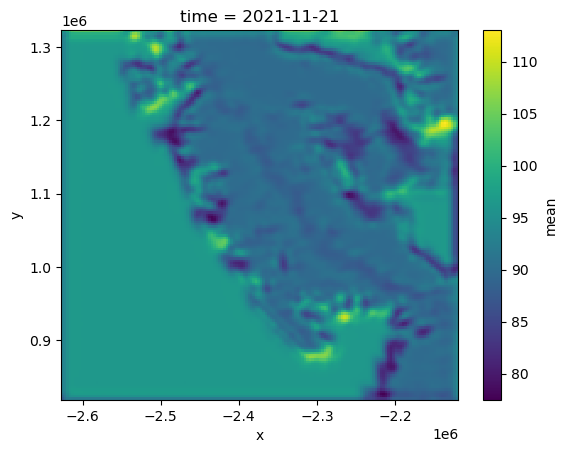

NameError: name 'patches_clipped' is not defined

In [ ]:
i = [0, 1,2,3,4,5]
for img in i:

    preds[img]['sea_ice_concentration']['mean'].plot()
    plt.show()
    patches_clipped[img]['mean'].plot()
    plt.show()

        


            

In [ ]:
def get_single_index_value(val, x1 = True):
    if x1:
        index_position = np.argmin(np.abs(amsr_raw_ds.coords['y'].values - val))
    else:
        index_position = np.argmin(np.abs(amsr_raw_ds.coords['x'].values - val))
    print('single index position', index_position)    
    return index_position


def get_index_value(patch_x1, patch_x2, verbose = False):
    x1_index = []
    for target_x1 in patch_x1:
        
        x1_index_position = np.argmin(np.abs(amsr_raw_ds.coords['y'].values - target_x1))
        x1_index.append(x1_index_position)
    x2_index = []
    for target_x2 in patch_x2:
        
        x2_index_position = np.argmin(np.abs(amsr_raw_ds.coords['x'].values - target_x2))
        x2_index.append(x2_index_position)
    
    if verbose:
        print('index values for patch: ', x1_index, x2_index)
    return (x1_index, x2_index)



data_x1 = amsr_raw_ds.coords['y'].min().values, amsr_raw_ds.coords['y'].max().values
data_x2 = amsr_raw_ds.coords['x'].min().values, amsr_raw_ds.coords['x'].max().values   
data_x1_index, data_x2_index = get_index_value(data_x1, data_x2, verbose = True)


patches_clipped = {var_name: [] for var_name in preds[0].keys()}

#patches_per_row = 5 ## Resolve so it is automated
border = 16
print('border', border)
for i, patch_pred in enumerate(preds):
    for var_name, data_array in patch_pred.items(): #previously patch
        if var_name in pred_copy:
            # min max coordinate values- to substitute with find_min_max_x_y_values(datasets)
            patch_x1 = data_array['y'].min().values, data_array['y'].max().values
            patch_x2 = data_array['x'].min().values, data_array['x'].max().values
            # get row/col index values for patch


            patch_x1_index, patch_x2_index =  get_index_value(patch_x1, patch_x2, verbose = True)
            print('unclipped coords', int(patch_x1[0]), int(patch_x1[1]), int(patch_x2[0]), int(patch_x2[1]))
            #print('entire extent', data_x1_index, data_x2_index)
            #print(patch_x1, patch_x2)
            #channels, x1_max_patch, x2_max_patch = tuple(data_array.dims.values()) # channels, height and width of patch in pixels
            #print( channels, x1_max_patch, x2_max_patch)
            b_x1_min, b_x1_max, b_x2_min, b_x2_max = border, border, border, border
            
            print('patch shape', data_array.sizes['y'], data_array.sizes['x'])
            # Do not remove border for the patches along top and left of dataset
            if patch_x2_index[0] == data_x2_index[0]:
                print('x2 min')
                b_x2_min = 0
            # Resolve different overlaps for last patches in rows and columns
            elif patch_x2_index[1] == data_x2_index[1]:
                print('x2 max')
                b_x2_max = 0
                patch_row_prev = preds[i-1]
                prev_patch_x2_max = get_single_index_value(int(patch_row_prev[var_name].coords['x'].max()), x1 = False)
                
                b_x2_min = (prev_patch_x2_max - patch_x2_index[0])-border

            if patch_x1_index[0] == data_x1_index[0]:
                print('x1_min')
                b_x1_min = 0
            elif abs(patch_x1_index[1] - data_x1_index[1])<2:

                b_x1_max = 0
                patch_prev = preds[i-patches_per_row]
                prev_patch_x1_max = get_single_index_value(int(patch_prev[var_name].coords['y'].max()), x1 = True)
                
                b_x1_min = (prev_patch_x1_max - patch_x1_index[0])- border
               
            print(b_x1_min, b_x1_max, b_x2_min, b_x2_max)
            #print(int(b_x1_min), int(patch_x1_index[1] - b_x1_max), int(b_x2_min), int(patch_x2_index[1] - b_x2_max))
            patch_clip_x1_min = int(b_x1_min)
            patch_clip_x1_max = int(data_array.sizes['y'] - b_x1_max)
            patch_clip_x2_min = int(b_x2_min)
            patch_clip_x2_max = int(data_array.sizes['x'] - b_x2_max)
            print(int(patch_x1_index[0] + b_x1_min), int(patch_x1_index[1] - b_x1_max), int(patch_x2_index[0] + b_x2_min), int(patch_x2_index[1] - b_x2_max))
            print('final snip', patch_clip_x1_min, patch_clip_x1_max, patch_clip_x2_min, patch_clip_x2_max)
            patch_clip = data_array.isel(y=slice(patch_clip_x1_min, patch_clip_x1_max),
                                         x=slice(patch_clip_x2_min, patch_clip_x2_max))
            #patch_clip = data_array.isel(y=slice(int(b_x1_min), int(patch_x1_index[1] - b_x1_max)),
            #                    x=slice(int(b_x2_min), int(patch_x2_index[1] - 10)))
                                    
            print('clipped coords', patch_clip['y'].min().values, patch_clip['y'].max().values, patch_clip['x'].min().values, patch_clip['x'].max().values)
            patches_clipped.append(patch_clip)

index values for patch:  [0, 324] [0, 644]


KeyError: "No variable named 0. Variables on the dataset include ['mean', 'std', 'y', 'x', 'time']"

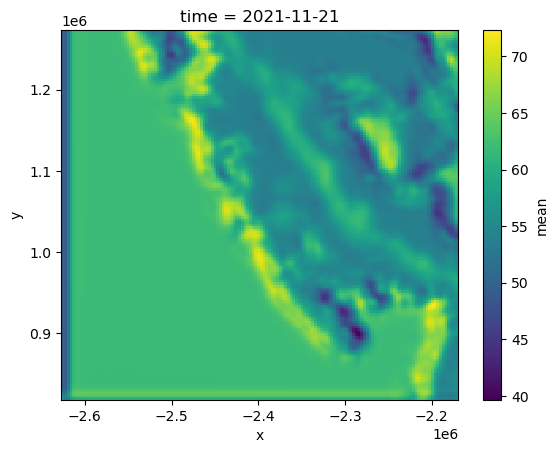

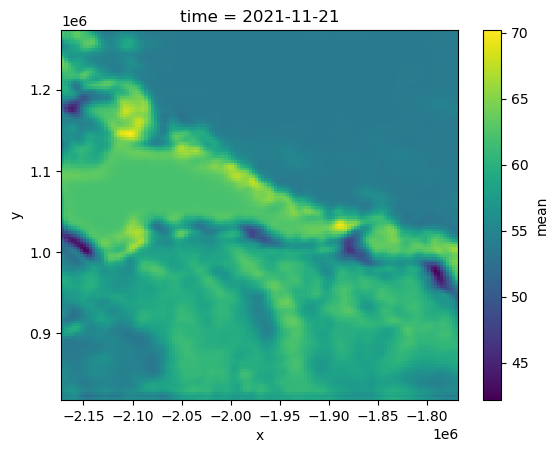

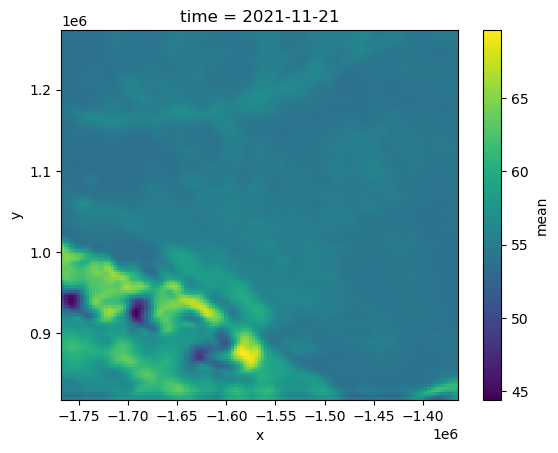

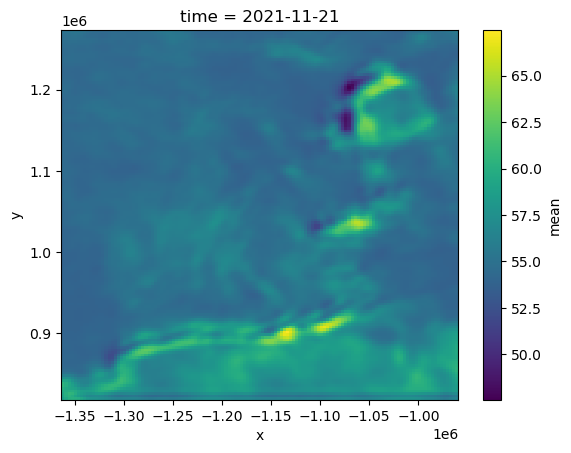

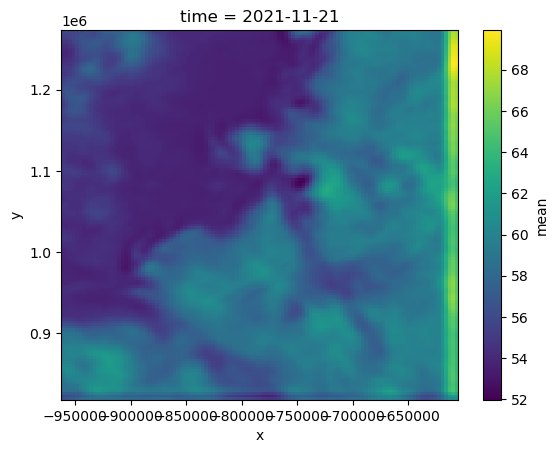

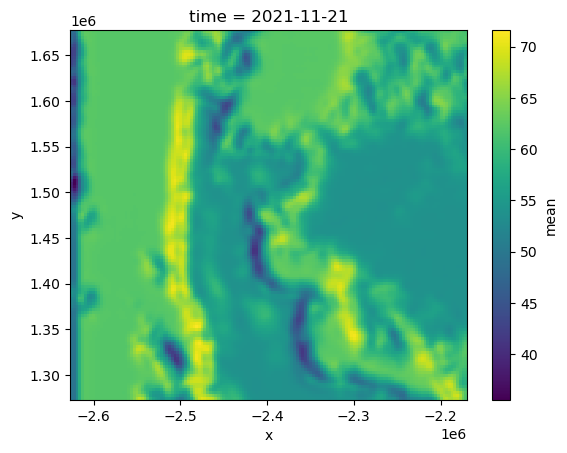

15


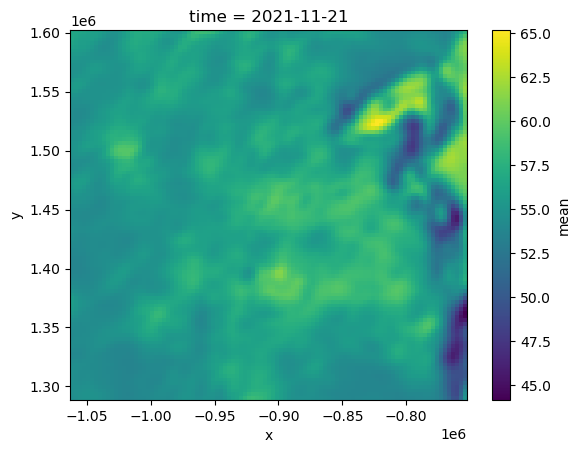

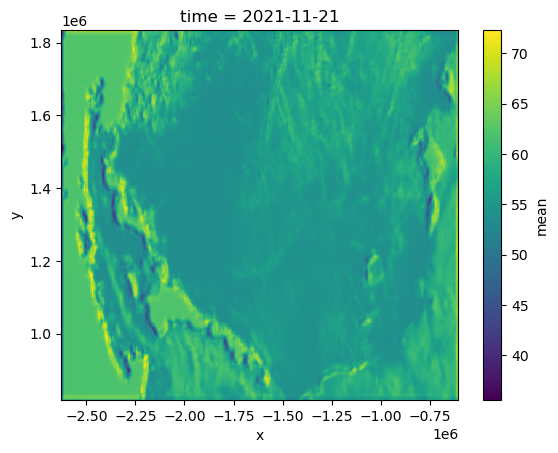

In [ ]:
i = [0, 1,2,3,4,5]
for img in i:

    patches_clipped[img]['mean'].plot()
    plt.show()
print(len(patches_clipped))
combined = xr.combine_by_coords(patches_clipped, compat='no_conflicts')
subset = combined.isel(y=slice(150, 250), x=slice(500,600))
#combined
subset['mean'].plot()
plt.show()
combined['mean'].plot()
plt.show()

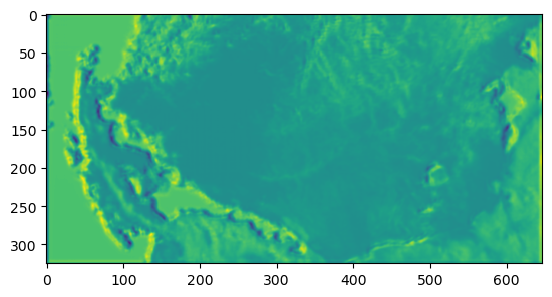

(325, 647)


In [ ]:
import rasterio
from rasterio.plot import show
# Save the DataArray as a TIFF file
output_tiff_path = 'combined_output_a.tiff'

# Define the transform and CRS (Coordinate Reference System)
#transform = from_origin(0, 10, 1, 1)  # Example transform (origin_x, origin_y, pixel_size_x, pixel_size_y)
crs = 'EPSG:3031'  # Example CRS (WGS84)
arr_combined = np.asarray(combined['mean'].values)
arr_combined = np.flip(arr_combined.squeeze(0), axis = 0)
show(arr_combined)
print(arr_combined.shape)
# Save using rasterio
#x1_map=(820052.4534908909, 2838808.8697723807) and x2_map=(-2625435.9375827303, -606679.5213012407) 
#raster_transform=[res,0,ul_x_sar, 0, -res, ul_y_sar]
transform = [3125, 0, -2625435.9375827303, 3125, 0, 820052.4534908909]  # Example transform (origin_x, origin_y, pixel_size_x, pixel_size_y)
with rasterio.open(
    output_tiff_path, 'w', driver='GTiff',
    height=arr_combined.shape[0], width=arr_combined.shape[1],
    count=1, dtype=arr_combined.dtype, transform = afn,
    crs=crs) as dst:
    dst.write(arr_combined, 1)

In [ ]:
test_task = task_loader("2021-11-21", context_sampling=["all", "all"], target_sampling="all")

# Note, i need to make data processor an obligatory input for predict_patch
pred = model.predict(test_task, X_t=amsr_raw_ds)
pred

{'sea_ice_concentration': <xarray.Dataset>
 Dimensions:  (time: 1, y: 325, x: 645)
 Coordinates:
   * y        (y) float64 8.201e+05 8.232e+05 8.263e+05 ... 1.833e+06 1.836e+06
   * x        (x) float64 -2.625e+06 -2.622e+06 ... -6.098e+05 -6.067e+05
   * time     (time) datetime64[ns] 2021-11-21
 Data variables:
     mean     (time, y, x) float32 56.32 53.44 54.44 57.7 ... 60.51 61.54 60.95
     std      (time, y, x) float32 28.87 30.58 31.56 32.1 ... 29.02 29.68 30.3}

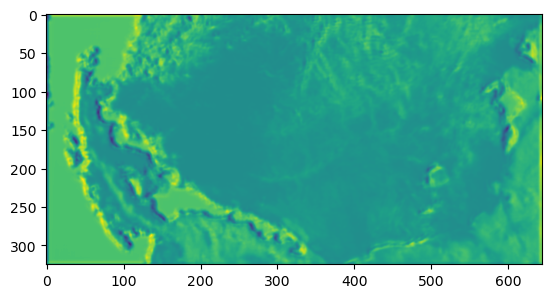

(325, 645)


In [ ]:

import rasterio
from rasterio.plot import show
from affine import Affine

# Save the DataArray as a TIFF file
output_tiff_path = 'non_patched_output_a.tiff'

# Define the transform and CRS (Coordinate Reference System)
im_transform = (-2627584.0, 3125.0, 0.0, 1838592.0, 0.0, -3125.0)

afn = Affine.from_gdal(*im_transform)
crs = 'EPSG:3031'  # Example CRS (WGS84)
arr = np.asarray(pred['sea_ice_concentration']['mean'].values)
arr = np.flip(arr.squeeze(0), axis = 0)
show(arr)
print(arr.shape)
# Save using rasterio
with rasterio.open(
    output_tiff_path, 'w', driver='GTiff',
    height=arr.shape[0], width=arr.shape[1],
    count=1, dtype=arr.dtype, transform = afn,
    crs=crs) as dst:
    dst.write(arr, 1)

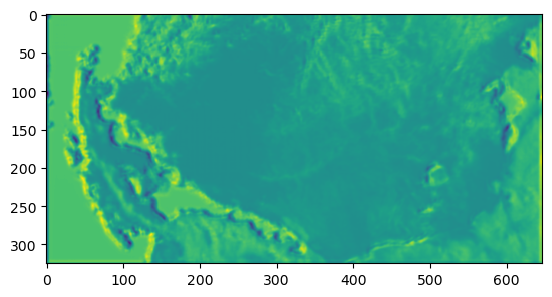

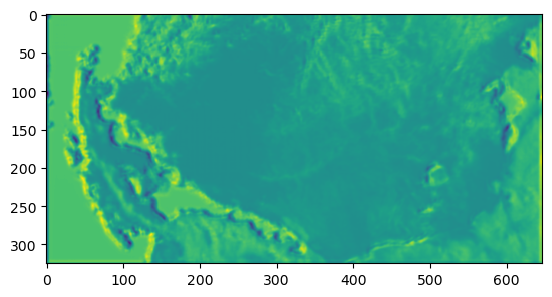

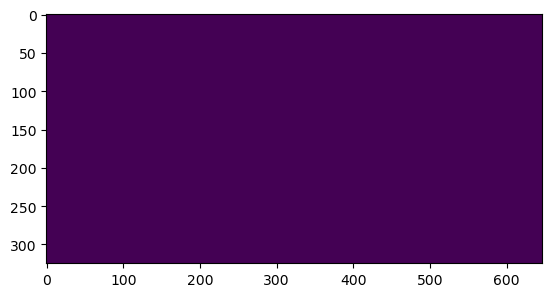

(325, 647) (325, 647)


In [ ]:
### Calculate difference between patched and array and one that predicts on entire extent ###
output_tiff_path = 'difference_patched_vs_entireExtent.tiff'
diff = arr_combined-arr
show(arr)
show(arr_combined)
show(diff)
print(arr.shape, arr_combined.shape)
with rasterio.open(
    output_tiff_path, 'w', driver='GTiff',
    height=diff.shape[0], width=diff.shape[1],
    count=1, dtype=diff.dtype, transform = afn,
    crs=crs) as dst:
    dst.write(diff, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

-2625435.9375827303 -2170914.788757776
820052.4534908909 1271469.9728470782
145 146
-2170914.788757776 -1769685.230528968
820052.4534908909 1271469.9728470782
145 129
-1766543.4773282025 -1365326.0682605652
820052.4534908909 1271469.9728470782
145 129
-1362184.7722971726 -960930.8572424306
820052.4534908909 1271469.9728470782
145 129
-860603.7774999363 -606679.5213012408
820052.4534908909 1271469.9728470782
145 82
-2625435.9375827303 -2170914.788757776
1274601.69021627 1675853.0016629295
129 146
-2170914.788757776 -1769685.230528968
1274601.69021627 1675853.0016629295
129 129
-1766543.4773282025 -1365326.0682605652
1274601.69021627 1675853.0016629295
129 129
-1362184.7722971726 -960930.8572424306
1274601.69021627 1675853.0016629295
129 129
-860603.7774999363 -606679.5213012408
1274601.69021627 1675853.0016629295
129 82
-2625435.9375827303 -2170914.788757776
1776149.1143741214 1832577.057887392
19 146
-2170914.788757776 -1769685.230528968
1776149.1143741214 1832577.057887392
19 129
-176

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-860603.7774999363 -606679.5213012408
1776149.1143741214 1832577.057887392
19 82


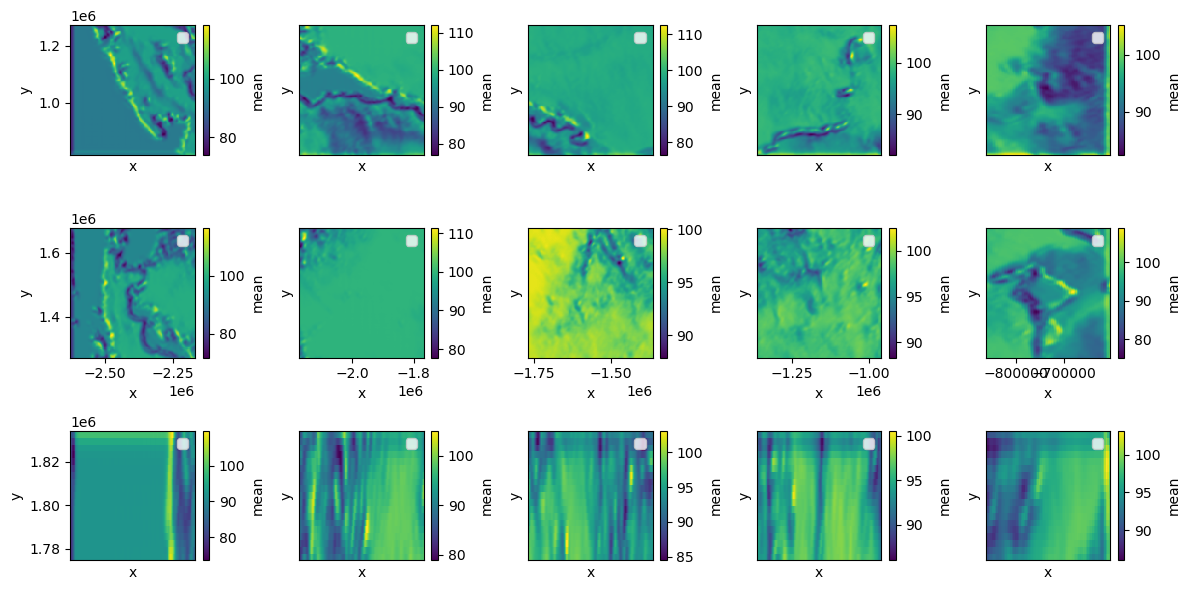

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(12, 6))  # 2 rows, 4 columns
for i in range(len(patches_clipped)):
    row = i // 5  # Calculate row index
    col = i % 5   # Calculate column index

    pred = patches_clipped[i]
    x_values = pred['mean'].coords['x'].values
    print(x_values.min(), x_values.max())

    y_values = pred['mean'].coords['y'].values
    print(y_values.min(), y_values.max())
    print(len(y_values), len(x_values))
    axes[row, col].set_title(None)
    pred['mean'].plot(ax=axes[row, col])
    axes[row, col].set_title(None)
    if col != 0:
        axes[row, col].set_yticks([])

    if row != 1:
        axes[row, col].set_xticks([])

    # if col != 3:
    axes[row, col].legend().set_title('')
    axes[row, col].set_title(None)
    #axes[row, col].plot(pred['mean'][0])
plt.tight_layout()
plt.show()

In [ ]:
#Inferring x1_map=(820052.4534908909, 2838808.8697723807) and x2_map=(-2625435.9375827303, -606679.5213012407) 
patches_clipped = []
patches_per_row = 2 ## Resolve so it is automated
border = (preds[0]['sea_ice_concentration']['x'].values.max() - preds[1]['sea_ice_concentration']['x'].values.min())/2
print('border', border)
for i, patch_pred in enumerate(preds):
    for var_name, data_array in patch_pred.items(): #previously patch
        if var_name in pred_copy:
            # min max coordinate values- to substitute with find_min_max_x_y_values(datasets)
            patch_x1 = data_array['x'].min().values, data_array['x'].max().values
            patch_x2 = data_array['y'].min().values, data_array['y'].max().values
            #print(patch_x1, patch_x2)
            #channels, x1_max_patch, x2_max_patch = tuple(data_array.dims.values()) # channels, height and width of patch in pixels
            #print( channels, x1_max_patch, x2_max_patch)
            b_x1_min, b_x1_max, b_x2_min, b_x2_max = border, border, border, border
            print(int(data_array.coords['x'].min()),
                int(data_array.coords['x'].max()),
                int(data_array.coords['y'].min()),
                int(data_array.coords['y'].max()))
            # Do not remove border for the patches along top and left of dataset
            if patch_x1[0] == X_t_min_x:
                b_x1_min = 0
            # Resolve different overlaps for last patches in rows and columns
            elif patch_x1[1] == X_t_max_x:
                b_x1_max = 0
                patch_row_prev = preds[i-1]

                b_x1_min = (int(patch_row_prev[var_name].coords['x'].max(
                ) - data_array.coords['x'].min()))-border

            if patch_x2[0] == X_t_min_y:
                b_x2_min = 0
            elif patch_x2[1] - X_t_max_y < 1000:
                b_x2_max = 0
                patch_prev = preds[i-patches_per_row]

                b_x2_min = (int(patch_prev[var_name].coords['y'].max(
                ) - data_array.coords['y'].min()))-border

            print(patch_x1[0] + b_x1_min, patch_x1[1] - b_x1_max, patch_x2[0] + b_x2_min, patch_x2[1] - b_x2_max)
            patch_clip = data_array.sel(x=slice(int(patch_x1[0] + b_x1_min), int(patch_x1[1] - b_x1_max)),
                                    y=slice(int(patch_x2[0] + b_x2_min), int(patch_x2[1] - b_x2_max)))

            patches_clipped.append(patch_clip)

#Inferring x1_map=(820052.4534908909, 2838808.8697723807) and x2_map=(-2625435.9375827303, -606679.5213012407) 


border 50148.115276136436
-2625435 -2120766 820052 1321621
-2625435.9375827303 -2170914.6470847167 820052.4534908909 1271473.6388181662
-2221062 -1719536 820052 1321621
-2170914.6470847167 -1769684.7565528995 820052.4534908909 1271473.6388181662
-1816707 -1315155 820052 1321621
-1766559.6477202598 -1365303.4767276614 820052.4534908909 1271473.6388181662
-1412340 -910767 820052 1321621
-1362192.6451343861 -960915.4339554268 820052.4534908909 1271473.6388181662
-1108264 -606679 820052 1321621
-960916.095547392 -606679.5213012408 820052.4534908909 1271473.6388181662
-2625435 -2120766 1224452 1725994
-2625435.9375827303 -2170914.6470847167 1271473.5249823397 1725994.6437265412
-2221062 -1719536 1224452 1725994
-2170914.6470847167 -1769684.7565528995 1271473.5249823397 1725994.6437265412
-1816707 -1315155 1224452 1725994
-1766559.6477202598 -1365303.4767276614 1675846.5249823397 1725994.6437265412
-1412340 -910767 1224452 1725994
-1362192.6451343861 -960915.4339554268 1675846.5249823397 172

ValueError: cannot reindex or align along dimension 'y' because the (pandas) index has duplicate values

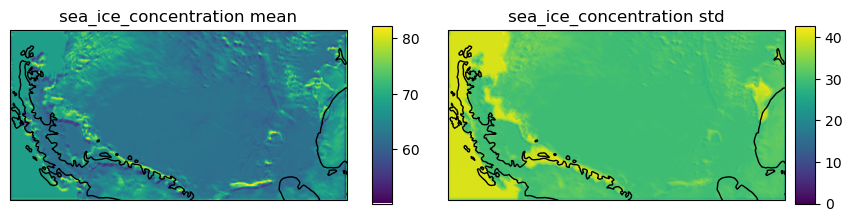

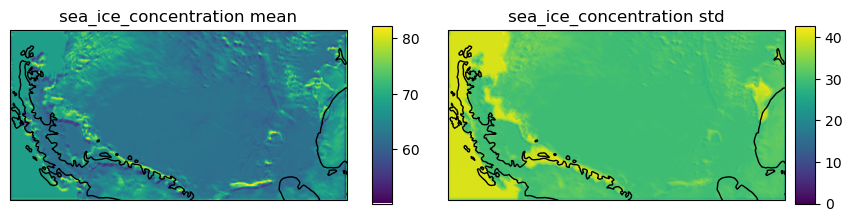

In [ ]:
# Test when I don't patch
test_task = task_loader("2021-11-27", context_sampling=["all", "all"], target_sampling="all",
                        )

pred = model.predict(test_task, X_t=amsr_raw_ds)
test_task
deepsensor.plot.prediction(pred, "2021-11-27", data_processor,
                           task_loader, test_task, crs=ccrs.SouthPolarStereo())

In [ ]:
# Function to find the minimum and maximum x and y values in original coordinates for all datasets in prediction object
def find_min_max_x_y_values(datasets):
    min_x_values = []
    max_x_values = []
    min_y_values = []
    max_y_values = []
    for dataset in datasets.values():
        print(dataset.coords['x'].min().item(), dataset.coords['x'].max().item(), dataset.coords['y'].min().item(), dataset.coords['y'].max().item())
        min_x_values.append(dataset.coords['x'].min().values)
        max_x_values.append(dataset.coords['x'].max().values)
        min_y_values.append(dataset.coords['y'].min().values)
        max_y_values.append(dataset.coords['y'].max().values)
    overall_min_x = min(min_x_values)
    overall_max_x = max(max_x_values)
    overall_min_y = min(min_y_values)
    overall_max_y = max(max_y_values)
    return overall_min_x, overall_max_x, overall_min_y, overall_max_y

# Get the minimum x value across all datasets
X_t_min_x, X_t_max_x, X_t_min_y, X_t_max_y = find_min_max_x_y_values(pred_copy)
print(X_t_min_x, X_t_max_x, X_t_min_y, X_t_max_y)

In [ ]:
bbox = [0, 0.25, 0, 0.25]
## do all the calculations in pixels ##
x1 = xr.DataArray([bbox[0], bbox[1]], dims='x1', name='x1')
x2 = xr.DataArray([bbox[2], bbox[3]], dims='x2', name='x2')
bbox_norm = xr.Dataset(coords={'x1': x1, 'x2': x2})
# Unnormalise coordinates of bounding boxes
bbox_unnorm = data_processor.unnormalise(bbox_norm)
print(bbox_unnorm)

target_x1 = bbox_unnorm.coords['x'].values[1]
target_x2 = bbox_unnorm.coords['y'].values[1]
print('targets', target_x1, target_x2)
nearest_x1_index = amsr_raw_ds.sel(x=target_x1, method='nearest').x.values
nearest_x2_index = amsr_raw_ds.sel(y=target_x2, method='nearest').y.values

print(f"Nearest x1 index for coordinate {target_x1}: {nearest_x1_index}")
print(f"Nearest x2 index for coordinate {target_x2}: {nearest_x2_index}")

# Find the position of these indices within the DataArray
x_index_position = np.argmin(np.abs(amsr_raw_ds.coords['x'].values - target_x1))
y_index_position = np.argmin(np.abs(amsr_raw_ds.coords['y'].values - target_x2))

print(f"Row index for x coordinate {target_x1}: {x_index_position}")
print(f"Column index for y coordinate {target_x2}: {y_index_position}")

stride = [0, 0.2, 0, 0.2]
x1_stride = xr.DataArray([stride[0], stride[1]], dims='x1', name='x1')
x2_stride = xr.DataArray([stride[2], stride[3]], dims='x2', name='x2')
stride_norm = xr.Dataset(coords={'x1': x1_stride, 'x2': x2_stride})
# Unnormalise coordinates of bounding boxes
stride_unnorm = data_processor.unnormalise(stride_norm)
print(bbox_unnorm)

target_x1_stride = stride_unnorm.coords['x'].values[1]
target_x2_stride = stride_unnorm.coords['y'].values[1]
print('targets Stride', target_x1_stride, target_x2_stride)
nearest_x1_index_stride = amsr_raw_ds.sel(x=target_x1_stride, method='nearest').x.values
nearest_x2_index_stride = amsr_raw_ds.sel(y=target_x2_stride, method='nearest').y.values

print(f"Nearest x1 index for coordinate stride {target_x1_stride}: {nearest_x1_index_stride}")
print(f"Nearest x2 index for coordinate stride {target_x2_stride}: {nearest_x2_index_stride}")

# Find the position of these indices within the DataArray
x_index_position_stride = np.argmin(np.abs(amsr_raw_ds.coords['x'].values - target_x1_stride))
y_index_position_stride = np.argmin(np.abs(amsr_raw_ds.coords['y'].values - target_x2_stride))

print(f"Row index for x coordinate stride {target_x1_stride}: {x_index_position_stride}")
print(f"Column index for y coordinate stride {target_x2_stride}: {y_index_position_stride}")

